# Telecoms Churn Data Analysis and Predictive Modelling


A telecommunication company requires a predictive model to identify which customers will leave their telecoms plan. The restults will inform the Marketing and Cusomter Retention teams about which customers are likely to leave their plan so that resources can be directed to these customers.

In [2]:
churn_raw <- read.csv("https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv", header = T)

str(churn_raw)

'data.frame':	7043 obs. of  21 variables:
 $ customerID      : Factor w/ 7043 levels "0002-ORFBO","0003-MKNFE",..: 5376 3963 2565 5536 6512 6552 1003 4771 5605 4535 ...
 $ gender          : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Partner         : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : Factor w/ 3 levels "No","No phone service",..: 2 1 1 2 1 3 3 2 3 1 ...
 $ InternetService : Factor w/ 3 levels "DSL","Fiber optic",..: 1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : Factor w/ 3 levels "No","No internet service",..: 1 3 3 3 1 1 1 3 1 3 ...
 $ OnlineBackup    : Factor w/ 3 levels "No","No internet service",..: 3 1 3 1 1 1 3 1 1 3 ...
 $ DeviceProtection: Factor w/ 3 levels "No","

## Checking for missing values

In [3]:
sum(is.na(churn_raw))

[1] 11

## Where are the 11 missing values?

In [4]:
sapply(churn_raw, function(x) sum(is.na(x)))

customerID           gender    SeniorCitizen          Partner 
               0                0                0                0 
      Dependents           tenure     PhoneService    MultipleLines 
               0                0                0                0 
 InternetService   OnlineSecurity     OnlineBackup DeviceProtection 
               0                0                0                0 
     TechSupport      StreamingTV  StreamingMovies         Contract 
               0                0                0                0 
PaperlessBilling    PaymentMethod   MonthlyCharges     TotalCharges 
               0                0                0               11 
           Churn 
               0

All of the NAs are in the TotalCharges column, but I might be able to compute the total charges since we have data for monthly charges and tenure in months


In [5]:
churn_raw[is.na(churn_raw$TotalCharges),]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
489,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NA,No
754,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NA,No
937,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NA,No
1083,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NA,No
1341,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NA,No
3332,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NA,No
3827,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NA,No
4381,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NA,No
5219,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NA,No
6671,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NA,No


These customers all show tenure of zero months so they haven't made their first payment yet. Are there any other zero tenure customers in the data set?

In [6]:
library(tidyverse)

churn_raw %>%
    filter(tenure == 0) %>%
    summarize("Zero Tenure" = n())

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.1     v dplyr   0.7.4
v tidyr   0.7.2     v stringr 1.2.0
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Zero Tenure
11


These eleven are the only customers with zero tenure so they can safely be removed


In [7]:
churnnoNAs <- churn_raw[complete.cases(churn_raw),]
dim(churnnoNAs)

[1] 7032   21

## Data Cleaning

Customer ID isn't useful to our analysis, neither is Total Charges since it is highly correlated with Monthly Charges

In [8]:
churn_neat <- churnnoNAs %>%
                select(-customerID, -TotalCharges) %>%
                rename(Gender = gender, Tenure = tenure)

table(churn_neat$SeniorCitizen)


   0    1 
5890 1142 

In [9]:
churn_neat$SeniorCitizen <- as.factor(ifelse(churn_neat$SeniorCitizen == 1, "Yes", "No"))

table(churn_neat$SeniorCitizen)


  No  Yes 
5890 1142 

In [10]:
str(churn_neat)

'data.frame':	7032 obs. of  19 variables:
 $ Gender          : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ Partner         : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ Tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : Factor w/ 3 levels "No","No phone service",..: 2 1 1 2 1 3 3 2 3 1 ...
 $ InternetService : Factor w/ 3 levels "DSL","Fiber optic",..: 1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : Factor w/ 3 levels "No","No internet service",..: 1 3 3 3 1 1 1 3 1 3 ...
 $ OnlineBackup    : Factor w/ 3 levels "No","No internet service",..: 3 1 3 1 1 1 3 1 1 3 ...
 $ DeviceProtection: Factor w/ 3 levels "No","No internet service",..: 1 3 1 3 1 3 1 1 3 1 ...
 $ TechSupport     : Factor w/ 3 levels "No","No int

The variables OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV and StreamingMovies all require an internet connection and the variable MultipleLines needs a phone service so I will replace "No internet service" and "No phone service" with "No".

In [11]:
factorrenames <- names(churn_neat[9:14])
  
data <- churn_neat %>%
                        mutate_at(
                        .vars=factorrenames,
                        .funs=~recode_factor(., `No internet service`="No")) %>%
                                    mutate_at(
                                              .vars="MultipleLines",
                                              .funs=~recode_factor(., `No phone service`="No"))
  

str(data)


'data.frame':	7032 obs. of  19 variables:
 $ Gender          : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ Partner         : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ Tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 2 2 1 2 1 ...
 $ InternetService : Factor w/ 3 levels "DSL","Fiber optic",..: 1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : Factor w/ 2 levels "No","Yes": 1 2 2 2 1 1 1 2 1 2 ...
 $ OnlineBackup    : Factor w/ 2 levels "No","Yes": 2 1 2 1 1 1 2 1 1 2 ...
 $ DeviceProtection: Factor w/ 2 levels "No","Yes": 1 2 1 2 1 2 1 1 2 1 ...
 $ TechSupport     : Factor w/ 2 levels "No","Yes": 1 1 1 2 1 1 1 1 2 1 ...
 $ StreamingTV     : Factor w/ 2 levels "No","Yes

## Data Exploration

In [12]:
churnrate <- table(data$Churn) / nrow(data)

churnrate


      No      Yes 
0.734215 0.265785 

Over the entire data set, 26.5% of customers churned. 

Creating a trainControl object so that all of the models use 10-fold cross validation on the training data. I will then use the remaining 30% of the data to test the model accuracy.

I will be using the both area under the ROC curve (AUC) and Accuracy percentage as metrics for assessing model accuracy

In [13]:
set.seed(1)

#Shuffling data
rowindices <- sample(nrow(data))

data_shuffled <- data[rowindices,]

#Identifying row to split on for 70/30 training/test split
split <- round(nrow(data_shuffled) * 0.7)
split

[1] 4922

In [14]:
train <- data_shuffled[1:split,]
test <- data_shuffled[(split+1):nrow(data_shuffled),]

dim(train)
dim(test)
library(caret)

#Using 3 repeats of 10-fold cross validation to fit each model to the training data
control <- trainControl(
  method = "repeatedcv",
  number = 10,
  repeats = 3,
  summaryFunction = twoClassSummary,
  classProbs = TRUE,
  verboseIter = FALSE
)

[1] 4922   19

[1] 2110   19

Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift



## Logistic Regression Model

In [15]:
glm_model <- train(Churn ~ ., data = train,
                method="glm", 
                trControl = control,
                preProcess = c("center","scale")
                  )

glm_model

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."

Generalized Linear Model 

4922 samples
  18 predictor
   2 classes: 'No', 'Yes' 

Pre-processing: centered (22), scaled (22) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4430, 4429, 4430, 4430, 4429, 4429, ... 
Resampling results:

  ROC        Sens       Spec     
  0.8430737  0.8982642  0.5364381


### Predictive Capability

In [16]:
glm_pred <- predict(glm_model, newdata = test)


glmcm <- confusionMatrix(glm_pred, test[["Churn"]])
glmaccuracy <- glmcm$overall[c(1,3,4)]
glmcm

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1382  253
       Yes  154  321
                                          
               Accuracy : 0.8071          
                 95% CI : (0.7896, 0.8237)
    No Information Rate : 0.728           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4852          
 Mcnemar's Test P-Value : 1.188e-06       
                                          
            Sensitivity : 0.8997          
            Specificity : 0.5592          
         Pos Pred Value : 0.8453          
         Neg Pred Value : 0.6758          
             Prevalence : 0.7280          
         Detection Rate : 0.6550          
   Detection Prevalence : 0.7749          
      Balanced Accuracy : 0.7295          
                                          
       'Positive' Class : No              
                                          

## Generalised Linear Model - Ridge and Lasso Regression

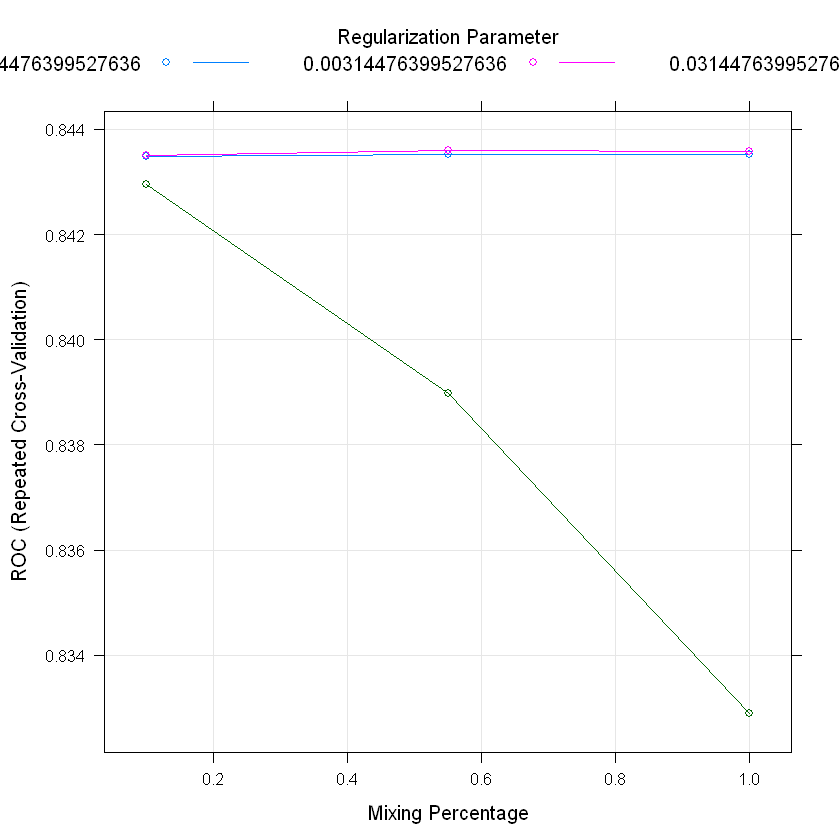

In [17]:
glmnet_model <- train(Churn ~ ., data = train,
  metric = "ROC",
  method = "glmnet",
  trControl = control,
  preProcess = c("center","scale")
)

plot(glmnet_model)

In [18]:
glmnet_model$bestTune$alpha

[1] 0.55

Alpha = 0.55 maximises AUC

### Predictive Capability

In [19]:
glmnet_pred <- predict(glmnet_model, newdata = test)

glmnetcm <- confusionMatrix(glmnet_pred, test[["Churn"]])
glmnetaccuracy <- glmnetcm$overall[c(1,3,4)]
glmnetcm

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1383  256
       Yes  153  318
                                          
               Accuracy : 0.8062          
                 95% CI : (0.7886, 0.8228)
    No Information Rate : 0.728           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4815          
 Mcnemar's Test P-Value : 4.569e-07       
                                          
            Sensitivity : 0.9004          
            Specificity : 0.5540          
         Pos Pred Value : 0.8438          
         Neg Pred Value : 0.6752          
             Prevalence : 0.7280          
         Detection Rate : 0.6555          
   Detection Prevalence : 0.7768          
      Balanced Accuracy : 0.7272          
                                          
       'Positive' Class : No              
                                          

## Random Forest

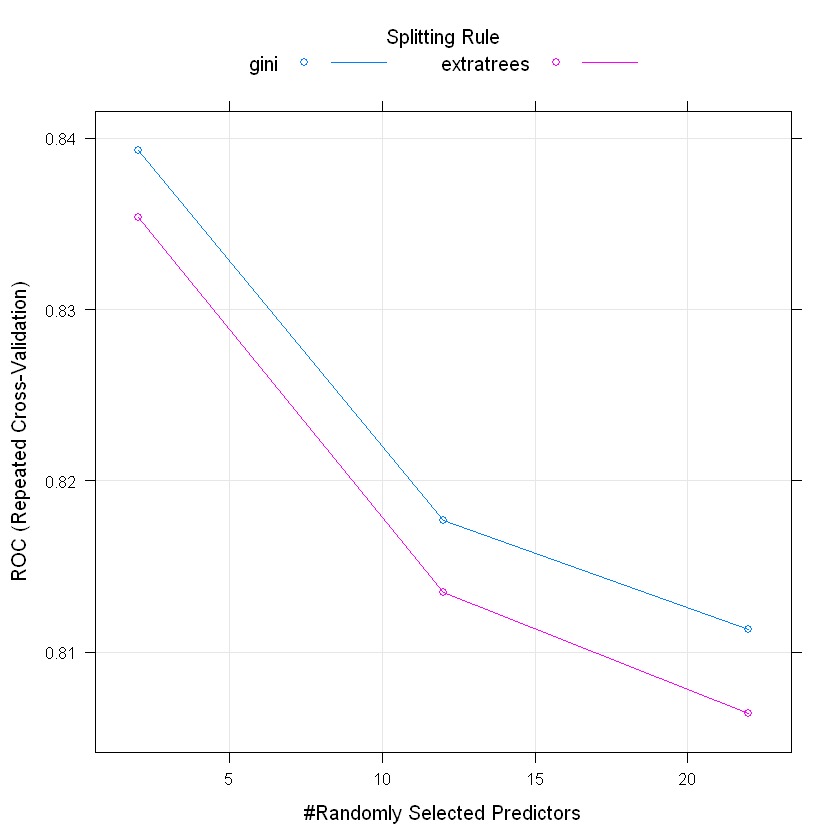

In [20]:
rf_model <- train(Churn ~ ., data=train,
  metric = "ROC",
  method = "ranger",
  trControl = control
)

plot(rf_model)

mtry = 2 yields the largest AUC value

### Predictive Capability

In [21]:
rf_pred <- predict(rf_model, newdata = test)
rfcm <- confusionMatrix(rf_pred, test[["Churn"]])
rfaccuracy <- rfcm$overall[c(1,3,4)]

## K-Nearest Neighbours

In [22]:
knn_model <- train(Churn ~ ., data = train, 
                   method = "knn", trControl = control,
                   preProcess = c("center","scale"), tuneLength = 50)

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."

k-Nearest Neighbors 

4922 samples
  18 predictor
   2 classes: 'No', 'Yes' 

Pre-processing: centered (22), scaled (22) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4431, 4430, 4430, 4430, 4429, 4429, ... 
Resampling results across tuning parameters:

  k    ROC        Sens       Spec     
    5  0.7690423  0.8422918  0.5060286
    7  0.7862659  0.8485391  0.5232936
    9  0.7962178  0.8513865  0.5281733
   11  0.8038834  0.8564409  0.5353787
   13  0.8084347  0.8613125  0.5431167
   15  0.8119438  0.8645313  0.5444047
   17  0.8134908  0.8631519  0.5456768
   19  0.8157295  0.8645290  0.5500596
   21  0.8180789  0.8671030  0.5554820
   23  0.8194283  0.8648968  0.5539276
   25  0.8210037  0.8675593  0.5570225
   27  0.8219666  0.8685697  0.5534287
   29  0.8227081  0.8681105  0.5549672
   31  0.8231535  0.8659990  0.5572868
   33  0.8231184  0.8654470  0.5601153
   35  0.8233364  0.8666418  0.5578076
   37  0.8238397  0.8659059  0.5598708
   39  

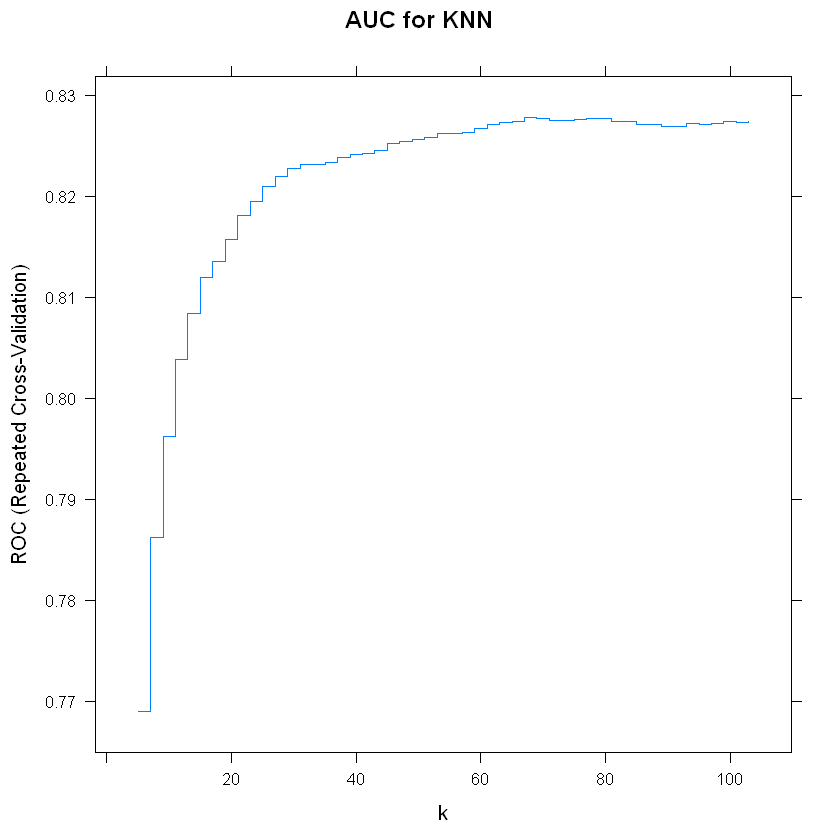

In [23]:
knn_model
plot(knn_model, type="s", main = "AUC for KNN", xlab = "k")

K = 75 maximised the AUC

### Predictive Capability

In [24]:
knn_pred <- predict(knn_model, newdata = test)
knncm <- confusionMatrix(knn_pred, test[["Churn"]])
knnaccuracy <- knncm$overall[c(1,3,4)]
knncm

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1336  249
       Yes  200  325
                                          
               Accuracy : 0.7872          
                 95% CI : (0.7691, 0.8045)
    No Information Rate : 0.728           
    P-Value [Acc > NIR] : 2.142e-10       
                                          
                  Kappa : 0.448           
 Mcnemar's Test P-Value : 0.0235          
                                          
            Sensitivity : 0.8698          
            Specificity : 0.5662          
         Pos Pred Value : 0.8429          
         Neg Pred Value : 0.6190          
             Prevalence : 0.7280          
         Detection Rate : 0.6332          
   Detection Prevalence : 0.7512          
      Balanced Accuracy : 0.7180          
                                          
       'Positive' Class : No              
                                          

## Support Vector Classifier

In [25]:
#Trying a range of values for the Cost parameter
grid <- expand.grid(C = c(0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25))

svm_linear_model <- train(Churn ~., data = train, method = "svmLinear",
                 trControl= control,
                 preProcess = c("center", "scale"),
                 tuneLength = 10,
                 tuneGrid = grid)

svm_linear_model

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. ROC will be used instead."

Support Vector Machines with Linear Kernel 

4922 samples
  18 predictor
   2 classes: 'No', 'Yes' 

Pre-processing: centered (22), scaled (22) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4430, 4429, 4430, 4431, 4430, 4430, ... 
Resampling results across tuning parameters:

  C     ROC        Sens       Spec     
  0.01  0.8386818  0.9039602  0.5161320
  0.05  0.8389704  0.9049706  0.5169112
  0.10  0.8388600  0.9056139  0.5161419
  0.25  0.8388919  0.9055221  0.5158835
  0.50  0.8388184  0.9058899  0.5164043
  0.75  0.8388427  0.9057973  0.5161439
  1.00  0.8387838  0.9059812  0.5161479
  1.25  0.8387519  0.9054300  0.5174379

ROC was used to select the optimal model using the largest value.
The final value used for the model was C = 0.05.

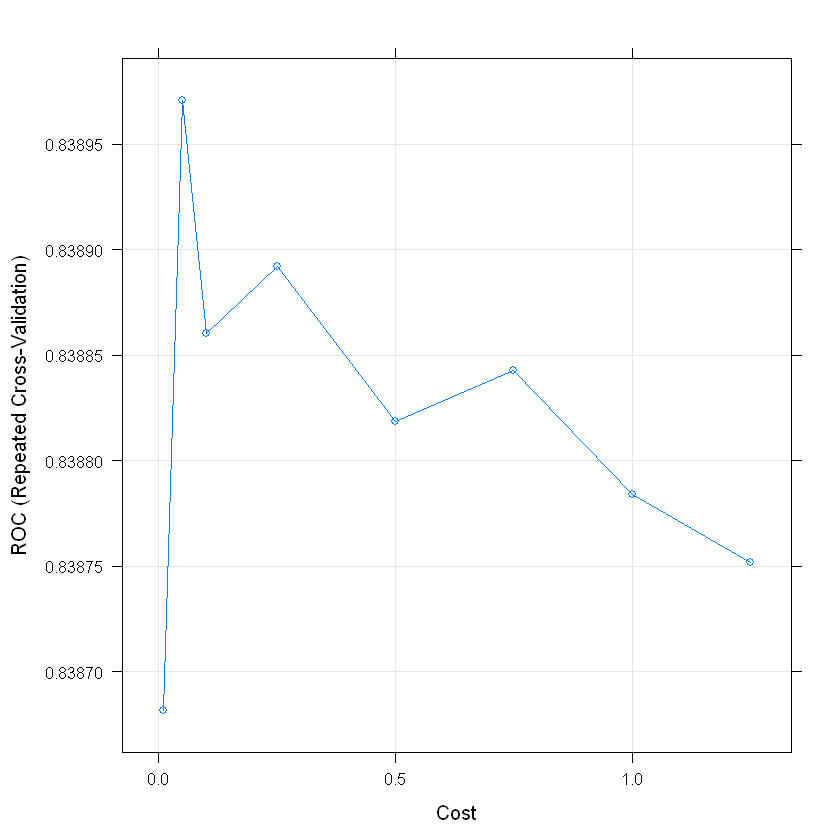

In [26]:
plot(svm_linear_model)

Cost of 0.01 produced the model with the greatest AUC

### Predictive Capability

In [27]:
svm_linear_pred <- predict(svm_linear_model, newdata = test)
svmcm <- confusionMatrix(svm_linear_pred, test[["Churn"]])
svmcm

svm_linearaccuracy <- svmcm$overall[c(1,3,4)]

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1385  268
       Yes  151  306
                                          
               Accuracy : 0.8014          
                 95% CI : (0.7837, 0.8183)
    No Information Rate : 0.728           
    P-Value [Acc > NIR] : 3.006e-15       
                                          
                  Kappa : 0.4644          
 Mcnemar's Test P-Value : 1.453e-08       
                                          
            Sensitivity : 0.9017          
            Specificity : 0.5331          
         Pos Pred Value : 0.8379          
         Neg Pred Value : 0.6696          
             Prevalence : 0.7280          
         Detection Rate : 0.6564          
   Detection Prevalence : 0.7834          
      Balanced Accuracy : 0.7174          
                                          
       'Positive' Class : No              
                                          

# Model Comparison

In [28]:
svm_linear_pred <- predict(svm_linear_model, newdata = test)
svmcm <- confusionMatrix(svm_linear_pred, test[["Churn"]])
svmcm

svm_linearaccuracy <- svmcm$overall[c(1,3,4)]

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1385  268
       Yes  151  306
                                          
               Accuracy : 0.8014          
                 95% CI : (0.7837, 0.8183)
    No Information Rate : 0.728           
    P-Value [Acc > NIR] : 3.006e-15       
                                          
                  Kappa : 0.4644          
 Mcnemar's Test P-Value : 1.453e-08       
                                          
            Sensitivity : 0.9017          
            Specificity : 0.5331          
         Pos Pred Value : 0.8379          
         Neg Pred Value : 0.6696          
             Prevalence : 0.7280          
         Detection Rate : 0.6564          
   Detection Prevalence : 0.7834          
      Balanced Accuracy : 0.7174          
                                          
       'Positive' Class : No              
                                          

In [31]:
model_list <- list("Logistic" = glm_model, "GLMnet" = glmnet_model, "Random Forest" = rf_model, "kNN" = knn_model, "SVM" = svm_linear_model)

resamples <- resamples(model_list)

summary(resamples)


Call:
summary.resamples(object = resamples)

Models: Logistic, GLMnet, Random Forest, kNN, SVM 
Number of resamples: 30 

ROC 
                   Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
Logistic      0.8024003 0.8340666 0.8437600 0.8430737 0.8520070 0.8776988    0
GLMnet        0.8108997 0.8331424 0.8456646 0.8435990 0.8549309 0.8801865    0
Random Forest 0.8086147 0.8291640 0.8429827 0.8392900 0.8473770 0.8695486    0
kNN           0.7794231 0.8131384 0.8270449 0.8277506 0.8403393 0.8739509    0
SVM           0.7911422 0.8280066 0.8381430 0.8389704 0.8464480 0.8755205    0

Sens 
                   Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
Logistic      0.8650138 0.8849862 0.8993121 0.8982642 0.9062714 0.9366391    0
GLMnet        0.8622590 0.8895789 0.9048293 0.9009259 0.9146006 0.9309392    0
Random Forest 0.8898072 0.9235024 0.9325069 0.9287744 0.9393521 0.9504132    0
kNN           0.8292011 0.8539945 0.8744844 0.8686656 0.8787879 0.9256198  

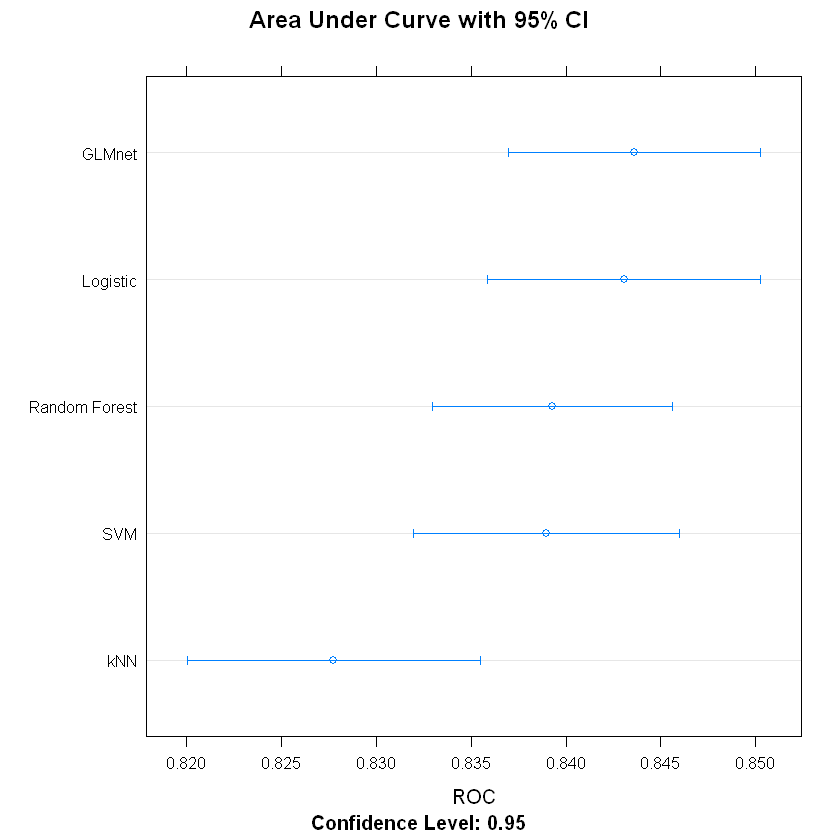

In [32]:
dotplot(resamples, metric="ROC", main = "Area Under Curve with 95% CI")

GLMnet and Logistic regression show the greatest predictive accuracy 

In [33]:
models <- c("Logistic", "GLMnet", "Random Forest", "SVM", "KNN")

accuracysummary <- bind_rows(Logistic = glmaccuracy, GLMnet = glmnetaccuracy, RandomForest = rfaccuracy, kNN = knnaccuracy, SVM = svm_linearaccuracy)

library(tibble)

accuracysummary2 <- add_column(accuracysummary, "Model" = models, .before = "Accuracy")

accuracysummary2

Model,Accuracy,AccuracyLower,AccuracyUpper
Logistic,0.8071090,0.7896145,0.8237460
GLMnet,0.8061611,0.7886366,0.8228308
Random Forest,0.7976303,0.7798425,0.8145874
SVM,0.7872038,0.7691103,0.8044959
KNN,0.8014218,0.7837495,0.8182526


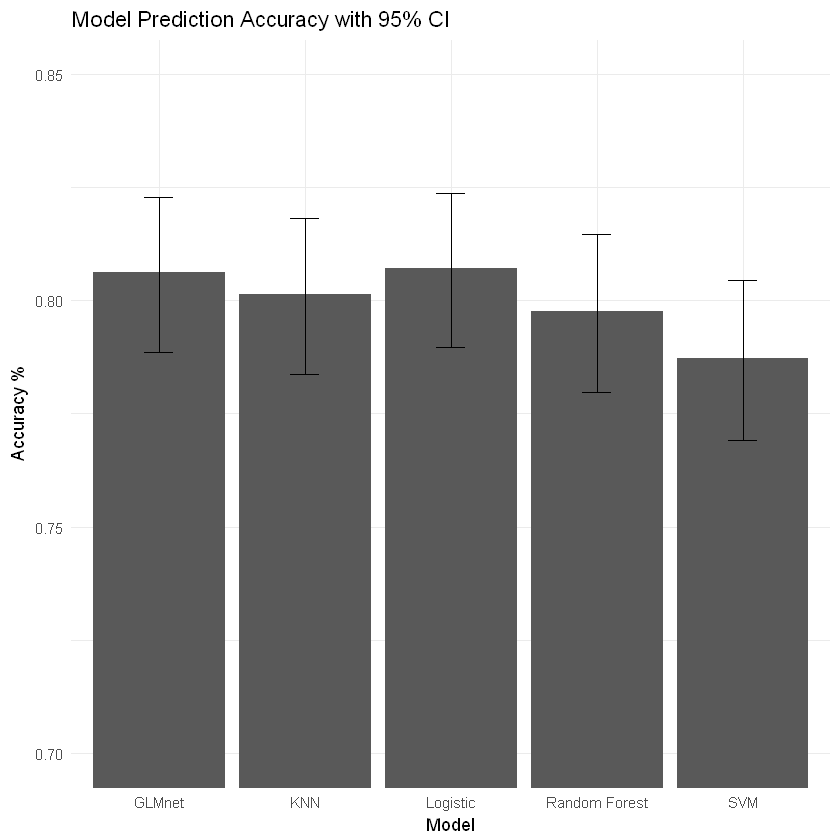

In [34]:
library(ggthemes)

ggplot(accuracysummary2, aes(x = Model, y = Accuracy)) + geom_bar(stat = "identity") + 
        geom_errorbar(width = 0.2, aes(ymin = AccuracyLower, ymax = AccuracyUpper), color = "black") +
        coord_cartesian(ylim = c(0.7, 0.85)) +
        labs(y = "Accuracy %", x = "Model", title = "Model Prediction Accuracy with 95% CI") +
        theme_minimal()

In this case all models show significantly greater predictive accuracy than the null model that predicts 'No' for every customer and has accuracy of 72.6%. The Logistic and GLMnet methods are almost identical in terms of results. 

Consequenly I would reccommend that the logistic model be used since it is much more interpretable than the GLMnet model that blends lasso and ridge regression since it is more interpretable.

## What does the profile customer that is likely to churn look like?

In [35]:
summary(glm_model)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9616  -0.6763  -0.2895   0.6848   3.1879  

Coefficients:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                            -1.67287    0.05798 -28.854  < 2e-16 ***
GenderMale                             -0.02474    0.03893  -0.636  0.52508    
SeniorCitizenYes                        0.06483    0.03750   1.729  0.08386 .  
PartnerYes                              0.02567    0.04608   0.557  0.57742    
DependentsYes                          -0.09396    0.04871  -1.929  0.05371 .  
Tenure                                 -0.82837    0.07096 -11.674  < 2e-16 ***
PhoneServiceYes                         0.05730    0.23485   0.244  0.80723    
MultipleLinesYes                        0.26181    0.10710   2.444  0.01451 *  
`InternetServiceFiber optic`            0.91411    0.48199   1.897  0.05789 .  
InternetServiceNo                      -0.71000    0.40515 

Tenure, ContratOneYear, ContractTwoYear and PaymentMethod are the most significant variables. This suggests that customers that have been with the company for a long time and those with contracts are the most likely to stay. 

In [36]:
levels(data$Contract)

[1] "Month-to-month" "One year"       "Two year"

Customers on month-to-month contracts are the most likely to churn, so incentivising these customers to take longer term contracts seems likely to reduce the churn rate

In [37]:
levels(data$PaymentMethod)

[1] "Bank transfer (automatic)" "Credit card (automatic)"  
[3] "Electronic check"          "Mailed check"

Payment by Electronic Check tend to churn much less, so incentivising this payment method is likely to reduce the churn rate